# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Научиться определять рыночную стоимость объектов недвижимости. Наша задача провести исследовательский анализ данных, который поможет установить параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Загружаем и изучаем данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
pd.options.mode.chained_assignment = None

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

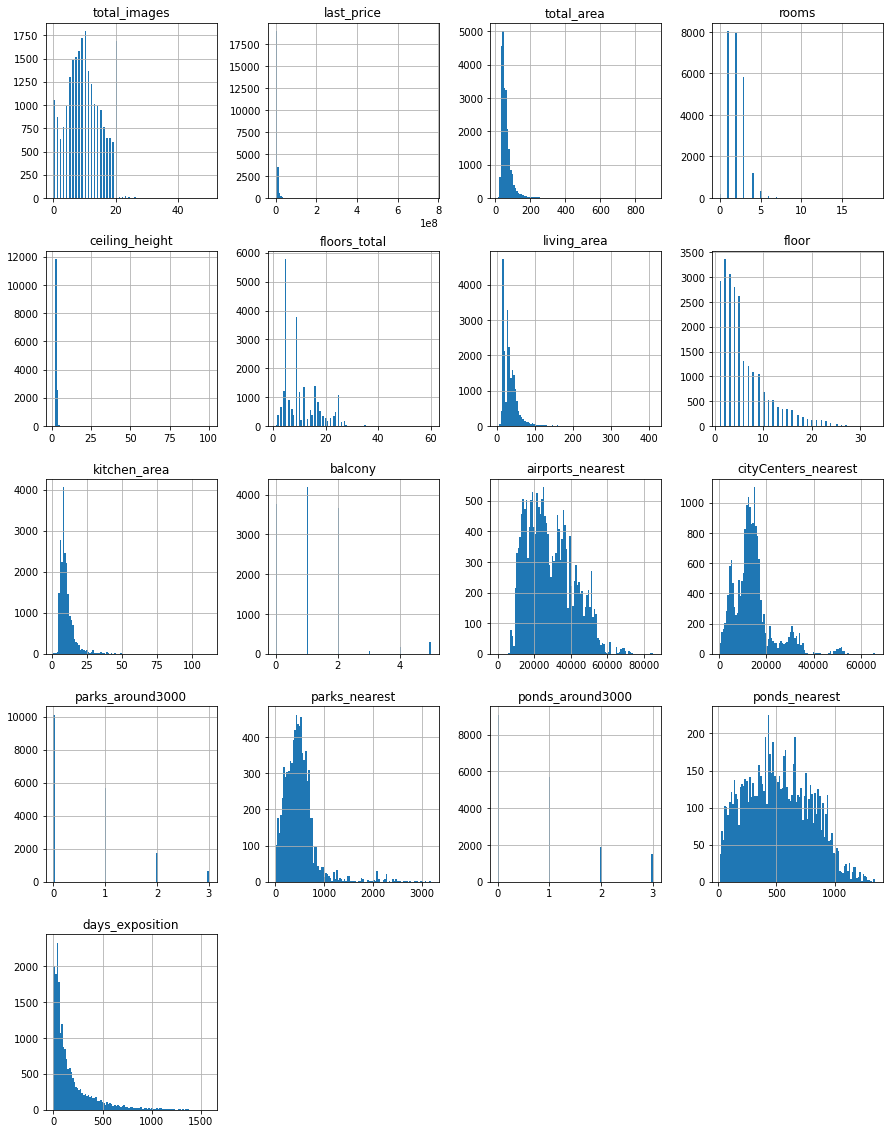

In [4]:
data.hist(figsize=(15, 20), bins=100);

### Предобработка данных

Определим и заполним пропуски.

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16, grid=True)
            .set(xlabel='Доля пропусков в процентном отношении к общему количеству данных', title='Пример' + "\n")
        );    
    except:
        print('пропусков не осталось :) ')

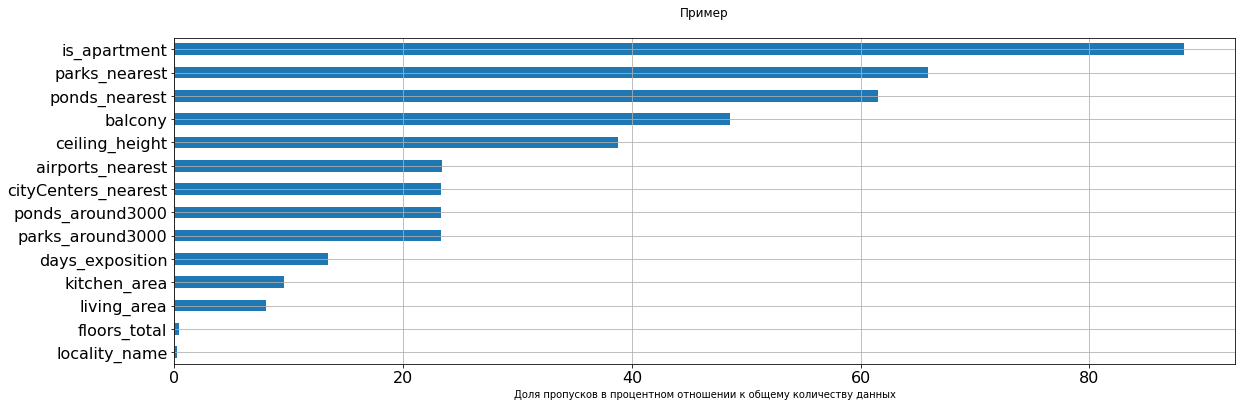

In [7]:
pass_value_barh(data)

In [8]:
data['balcony'] = data['balcony'].fillna(0)

Пропуски в названии населенных пунктов и этажности домов малочисленны - составляют менее 1% датафрейма, их удаление не повлияет на результаты.

In [9]:
data = data.dropna(subset=['floors_total'])
data = data.dropna(subset=['locality_name'])

<AxesSubplot:xlabel='total_area', ylabel='living_area'>

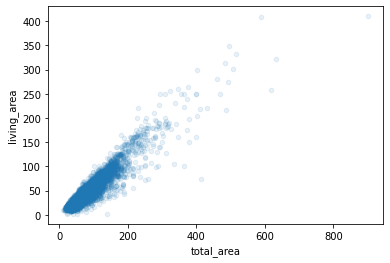

In [10]:
data.plot(x='total_area', y='living_area', kind='scatter', alpha=0.1);

In [11]:
data.loc[data['total_area']*0.9 < (data['living_area'] + data['kitchen_area'])]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,NaN,14.0,59.0,8,False,...,12.0,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
171,6,3800000.0,49.0,2019-02-22T00:00:00,2,2.50,9.0,38.0,8,NaN,...,10.0,1.0,посёлок Шушары,18471.0,24272.0,0.0,NaN,0.0,NaN,11.0
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.1,5,NaN,...,6.2,0.0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.0,6,NaN,...,9.0,0.0,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
319,19,4850000.0,59.7,2015-03-19T00:00:00,3,2.50,5.0,47.4,4,NaN,...,6.4,1.0,Санкт-Петербург,43095.0,15599.0,0.0,NaN,0.0,NaN,974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23216,15,10150000.0,114.0,2015-01-21T00:00:00,4,NaN,5.0,90.2,4,NaN,...,16.0,0.0,Санкт-Петербург,26259.0,4961.0,0.0,NaN,2.0,838.0,1052.0
23297,10,1850000.0,48.2,2019-03-13T00:00:00,2,NaN,5.0,42.2,2,NaN,...,6.0,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23328,12,4299000.0,54.0,2016-11-25T00:00:00,2,NaN,14.0,40.0,8,NaN,...,10.0,0.0,Колпино,25612.0,31399.0,0.0,NaN,0.0,NaN,343.0
23521,13,8500000.0,65.0,2018-11-01T00:00:00,2,NaN,4.0,44.0,2,NaN,...,15.3,0.0,Санкт-Петербург,22276.0,3996.0,1.0,627.0,0.0,NaN,NaN


In [13]:
data = data.loc[(data['total_area']*0.9 > (data['living_area'] + data['kitchen_area'])) | \
                (data['living_area'].isna()) | (data['kitchen_area'].isna())]

0.56

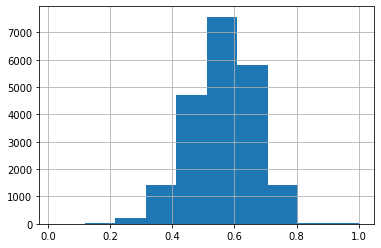

In [15]:
procent_count_liv = data.loc[(~data['living_area'].isna())]
procent_liv = procent_count_liv['living_area']/procent_count_liv['total_area']
procent_liv.hist()
mean_liv_procent = round(procent_liv.mean(),2)
mean_liv_procent

Как мы можем заметить, распределение отношения жилой к общей площади квартиры имеет распределение близкое к нормальному. Следовательно, заполняя пропуски в значениях жилой площади умножая общую площадь, пропусков в которой нет, на среднее отношение площадей в датафрейме получим значения, близкие к реальной картине.

In [16]:
print(data['living_area'].isna().sum())
data.loc[(data['kitchen_area'].isna()) & \
         (data['living_area'].isna()),'living_area'] = round(data['total_area'] * mean_liv_procent,2)
data['living_area'].isna().sum()

1865


438

<AxesSubplot:xlabel='total_area', ylabel='kitchen_area'>

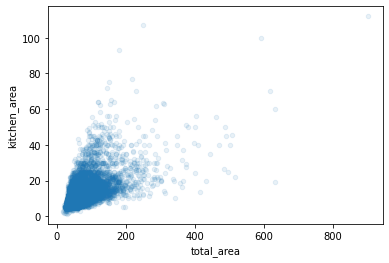

In [17]:
data.plot(x='total_area', y='kitchen_area', kind='scatter', alpha=0.1);

0.75

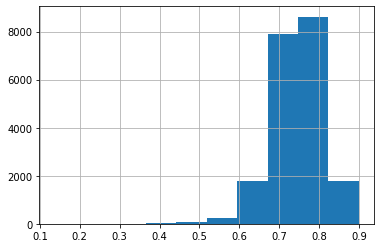

In [18]:
procent_count = data.loc[(~data['kitchen_area'].isna()) & (~data['living_area'].isna())]
procent_square = (procent_count['living_area'] + procent_count['kitchen_area'])/procent_count['total_area']
procent_square.hist()
mean_procent_square = round(procent_square.median(),2)
mean_procent_square

Исходя из графика и гистограммы, можно сказать, что площади кухни не имеют такой выраженной зависимости, как с жилой площадью квартир, но взять среднее значение площади кухни по всем квартирам тоже нецелесообразно, так как появятся случаи несходимости суммы площадей квартиры, поэтому заполнять будем значением общей площади квартиры, умноженное на медианное отношение площадей кухонь к общей.

In [19]:
len(data.loc[(data['kitchen_area'].isna()) & (data['living_area'].isna())])

0

In [20]:
data.loc[data['living_area'].isna(), 'living_area'] = round((data['total_area'] * mean_procent_square - data['kitchen_area']),2)
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = round((data['total_area'] * mean_procent_square - data['living_area']),2)

In [21]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           8915
floors_total                0
living_area                 0
floor                       0
is_apartment            20394
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5394
cityCenters_nearest      5371
parks_around3000         5370
parks_nearest           15236
ponds_around3000         5370
ponds_nearest           14237
days_exposition          3092
dtype: int64

In [22]:
data.query('total_area*0.9 <= (living_area + kitchen_area)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Высота потолков.
Заменим пропуски этих значений медианным значением.

In [24]:
print(round(data['ceiling_height'].std(),2))
print(round(data['ceiling_height'].var(),2))
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = round(data['ceiling_height'].median(), 2)
print(round(data['ceiling_height'].std(),2))
print(round(data['ceiling_height'].var(),2))

0.93
0.87
0.73
0.54


Логично предположить, что владельцы квартир не указывают в объявлениях параметр "апартаменты", потому что они таковыми не являются.

In [25]:
data.loc[data['is_apartment'].isna(), 'is_apartment'] = False

Определим характер пропусков в расстоянии и наличии парков.

In [26]:
print(data.loc[(data['parks_around3000'].isna()) & (data['ponds_around3000'].isna())]['total_area'].count())

5370


Квартиры не имеющие поблизости парков или водоемовм одни и те же.

In [27]:
print(data.loc[(data['parks_nearest'].isna()) & (data['parks_around3000'].isna())]['total_area'].count())
print(data.loc[(data['parks_nearest'].isna()) & (~data['parks_around3000'].isna())]['total_area'].count())
data.loc[(data['parks_nearest'].isna()) & (~data['parks_around3000'].isna())]['parks_around3000'].head(5)

5370
9866


1     0.0
6     0.0
7     0.0
9     0.0
11    0.0
Name: parks_around3000, dtype: float64

In [28]:
data.loc[data['parks_nearest'] > 3000, 'parks_nearest']

1590     3064.0
10959    3190.0
19208    3013.0
19430    3190.0
Name: parks_nearest, dtype: float64

Если отсутсвует расстояние до ближайшего парка, то и парка поблизости нет. Если нет парков поблизости, то и нет расстояния до ближайшего. Пропуски в количестве парков необходимо заменить на 0 и пропуски значений до ближайшего парка не являются ошибкой.

In [29]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)

Аналогично поступим с пропусками по водоемам.

In [30]:
print(data.loc[(data['ponds_nearest'].isna()) & (data['ponds_around3000'].isna())]['total_area'].count())
print(data.loc[(data['ponds_nearest'].isna()) & (~data['ponds_around3000'].isna())]['total_area'].count())
data.loc[(data['ponds_nearest'].isna()) & (~data['ponds_around3000'].isna())]['ponds_around3000'].head(5)

5370
8867


1     0.0
6     0.0
7     0.0
9     0.0
11    0.0
Name: ponds_around3000, dtype: float64

In [31]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Оценим характер пропусков расстояния до аэропорта.

In [32]:
len(data.loc[(data['airports_nearest'].isna()) & (data['locality_name'] == 'Санкт-Петербург'), 'airports_nearest'])

83

Необходимо устранить неявные дубликаты в названиях населенных пунктов.

In [33]:
print(len(data['locality_name'].unique()))
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё','е')
data['locality_name'] = data['locality_name'].str.replace('городского типа','')
data['locality_name'] = data['locality_name'].str.replace('городской ','')
data['locality_name'] = data['locality_name'].str.replace('поселок  ','поселок ')
data['locality_name'] = data['locality_name'].str.replace('село ','поселок ')
data['locality_name'] = data['locality_name'].str.replace('коттеджный ','')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество ','поселок ')
print(len(data['locality_name'].unique()))
data.duplicated().sum()


362
316


0

Заменим пропуски в расстояниях до аэропорта и в расстоянии до центра населенного пункта средним по населенному пункту. Если в населенных пунктах все объявления с пропусками, можно предположить что населенный пункт маленький, его центр не имеет особого значениям - заменим на 0.

In [35]:
data['airports_nearest'] = data['airports_nearest'].fillna(data.groupby(by='locality_name')['airports_nearest'].mean())
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data.groupby(by='locality_name')['cityCenters_nearest'].mean())
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)


In [36]:
data['airports_nearest'].max()

84869.0

In [37]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5394
cityCenters_nearest         0
parks_around3000            0
parks_nearest           15236
ponds_around3000            0
ponds_nearest           14237
days_exposition          3092
dtype: int64

##### Причины пропусков
Пропуски могли значить отрицательный смысл как в случае с апартаментами или наличием балконов, озер или парков поблизости, незначимость для владельца или незнание - высота потолка, жилой площади и площади кухни, этажность дома. Пропуски могли быть следствием ошибок или логикой алгоритмов - длительность размещения объявления, расстояние до аэропорта (могло указываться если менее 100км), название населенного пункта


##### Изменение типов данных

In [38]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,...,25.00,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.60,1,False,...,11.00,2.0,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.30,4,False,...,8.30,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,89.04,9,False,...,30.21,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,...,41.00,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [39]:
for i in ['floors_total','balcony','parks_around3000','ponds_around3000']:
    data[i] = data[i].astype(int)
    
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')   

data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.00,8,False,...,25.00,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.60,1,False,...,11.00,2,поселок шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.30,4,False,...,8.30,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,89.04,9,False,...,30.21,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.00,13,False,...,41.00,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


Логично что такие параметры как этажность дома, количество балконов, количество парков и озер поблизости не могут быть дробными - переводим в целочисленный формат. Дату переводим в удобный формат, все публикации были в полночь.

##### Определение и устранение аномалий

count    23091.000000
mean        10.394554
std          6.052487
min        -47.500000
25%          7.000000
50%          9.000000
75%         12.000000
max        135.000000
Name: kitchen_area, dtype: float64

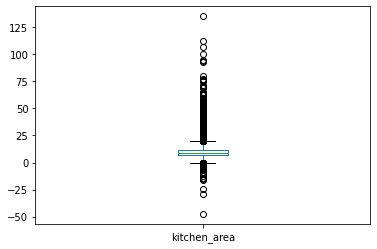

In [41]:
data['kitchen_area'].plot(kind='box')
display(data['kitchen_area'].describe())


<AxesSubplot:>

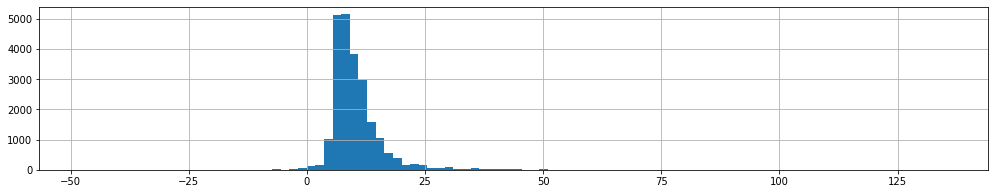

In [42]:
data['kitchen_area'].hist(bins=100, figsize=(17,3));

<AxesSubplot:>

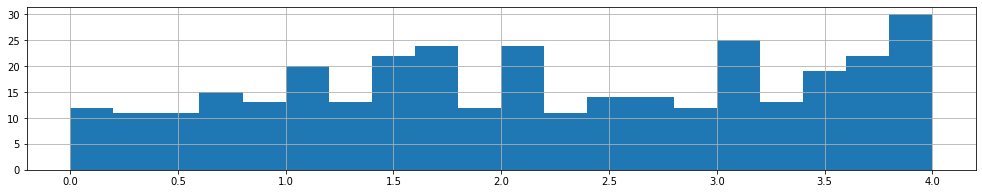

In [43]:
data['kitchen_area'].hist(bins=20, range=(0,4), figsize=(17,3));

<AxesSubplot:>

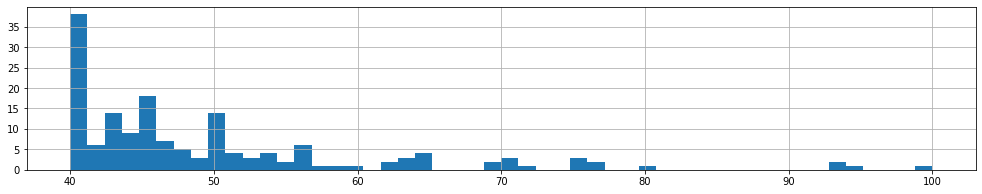

In [44]:
data['kitchen_area'].hist(bins=50, range=(40,100), figsize=(17,3));

Все что лежит выше верхнего уса и ниже нижнего, считается выбросом, это значения больше 17,75 и меньше 0.885 

In [46]:
data = data[(data['kitchen_area'] < 50) | (data['kitchen_area'].isna())]

<AxesSubplot:>

count    23027.000000
mean         2.716303
std          0.733799
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64
7


2

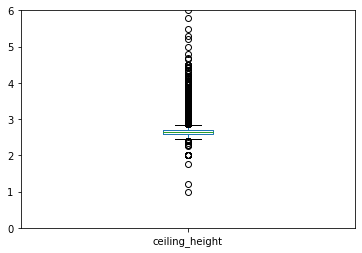

In [48]:
display(data['ceiling_height'].plot(kind='box', ylim=(0,6)))
print(data['ceiling_height'].describe())
print(data.loc[data['ceiling_height'] == 25,'ceiling_height'].count())
data.loc[data['ceiling_height'] == 32,'ceiling_height'].count()

Как видно по графику, с высотой потолков имеется много выбросов. В предложенном варианте зименить 25 и 32 метра на 2.5 и 3.2 соответственно мало смысла, так как таких случаев мало - проще их удалить, на общий исход это не повлияет. К тому же по такой логике можно и к площади кухни подойти. Убираем выбросы.

<AxesSubplot:>

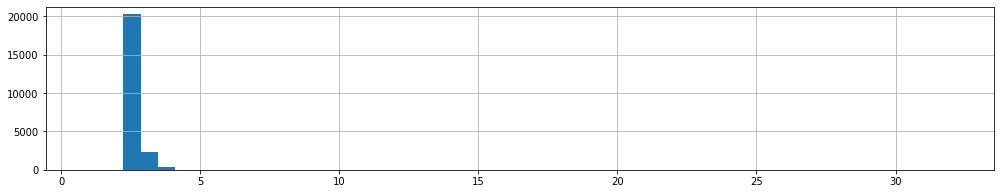

In [49]:
data['ceiling_height'].hist(bins=50, figsize=(17,3));

<AxesSubplot:>

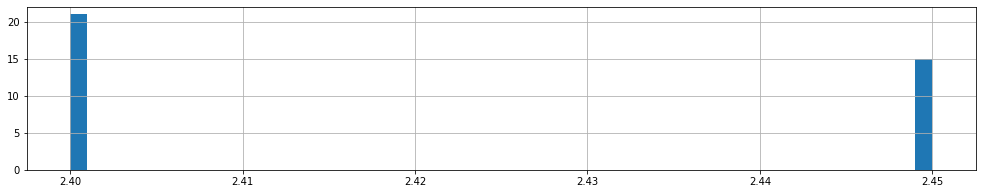

In [50]:
data['ceiling_height'].hist(bins=50, range=(2.4,2.45), figsize=(17,3));

<AxesSubplot:>

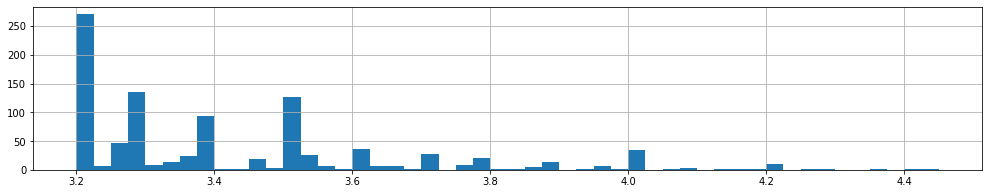

In [51]:
data['ceiling_height'].hist(bins=50, range=(3.2,4.45), figsize=(17,3));

In [52]:
print(data.shape[0])
data = data[(data['ceiling_height'] <= 3.8) & (data['ceiling_height'] >= 2.4)]
data.shape[0]

23027


22879

In [53]:
print(data['balcony'].describe())

count    22879.000000
mean         0.594956
std          0.959934
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64


5 балконов не сильно выдающаяся величина.

In [58]:
print(data['airports_nearest'].describe())
print(data.loc[data['airports_nearest'] < 1000,'airports_nearest'].count())

count    17521.000000
mean     28850.918155
std      12687.904054
min          0.000000
25%      18500.000000
50%      26890.000000
75%      37407.000000
max      84869.000000
Name: airports_nearest, dtype: float64
1


In [59]:
data = data[(data['airports_nearest'] > 1000) | (data['airports_nearest'].isna())]

Существует квартира в аэропорту, невозможно.

<AxesSubplot:>

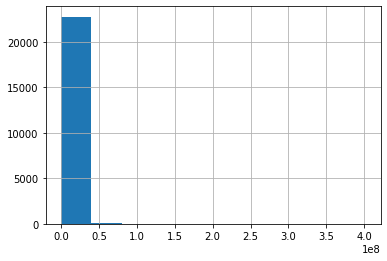

In [61]:
data['last_price'].hist();

In [62]:
data.loc[data['last_price'] > 100000000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7,95.00,5,False,...,40.00,0,санкт-петербург,23011.0,1197.0,3,519.0,3,285.0,233.0
1928,11,125000000.0,224.5,2017-01-24,4,2.65,4,163.50,3,False,...,30.00,1,санкт-петербург,22805.0,2335.0,0,NaN,2,497.0,174.0
4996,20,124000000.0,124.5,2017-10-12,4,3.00,4,67.20,2,False,...,20.00,0,санкт-петербург,20399.0,1722.0,3,302.0,3,172.0,45.0
5893,3,230000000.0,500.0,2017-05-31,6,2.65,7,335.00,7,False,...,40.00,0,санкт-петербург,32440.0,5297.0,0,NaN,2,198.0,50.0
7857,11,150000000.0,230.0,2017-10-25,8,2.65,8,220.00,8,False,...,-47.50,0,санкт-петербург,25525.0,5845.0,2,116.0,0,NaN,135.0
8900,13,190870000.0,268.0,2016-03-25,3,2.65,8,132.00,7,False,...,40.00,0,санкт-петербург,32440.0,5297.0,0,NaN,2,198.0,901.0
12674,16,140000000.0,241.0,2015-07-24,5,3.00,5,134.96,4,False,...,45.79,0,санкт-петербург,23512.0,3503.0,3,413.0,3,83.0,399.0
13749,7,240000000.0,410.0,2017-04-01,6,3.40,7,218.00,7,False,...,40.00,0,санкт-петербург,32440.0,5297.0,0,NaN,2,198.0,199.0
13864,20,130000000.0,231.0,2015-08-13,6,3.60,6,148.00,4,False,...,12.00,0,санкт-петербург,22992.0,1280.0,3,395.0,3,170.0,467.0
14706,15,401300000.0,401.0,2016-02-20,5,2.65,9,204.00,9,False,...,24.00,3,санкт-петербург,21912.0,2389.0,1,545.0,1,478.0,393.0


Элитное жилье дорого стоит..

In [64]:
# Проверим какие аномалии остались

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир

def check_param(data):
    (
        data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
              'floor', 'floors_total']]
        .apply (['count', 'min', 'max', 'median'])   
        .style.format("{:,.2f}")
    )

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,878.00","22,878.00","22,878.00","19,830.00","22,878.00","22,878.00","22,878.00","22,878.00","22,878.00"
min,0.00,12.00,2.40,1.00,"12,190.00",2.00,-47.50,1.00,1.00
max,19.00,517.00,3.80,"1,580.00","401,300,000.00",335.00,49.40,33.00,60.00
median,2.00,51.80,2.65,95.00,"4,600,000.00",30.00,9.00,4.00,9.00


In [1]:
# Значения параметров объектов недвижимости на разных квантилях

def check_qvan(data):
    (
        data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
            'kitchen_area', 'floor',   'floors_total']]
        .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
        .style.format("{:,.2f}")
    )

Определим аномалии и редкости (в т.ч. и хвосты) в колонках: 
        
'rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floors_total'

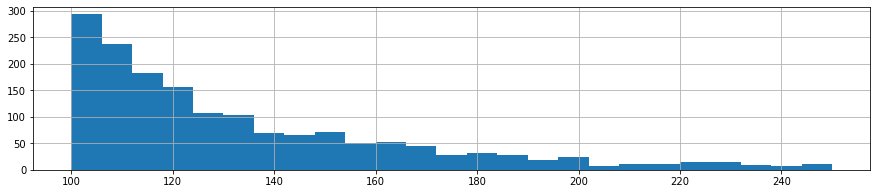

In [72]:
data.total_area.hist(bins = 25, figsize = (15,3), range = (100,250));

In [73]:
data = data[(data['total_area'] <= 250) & (data['total_area'] >= 20)]

<AxesSubplot:>

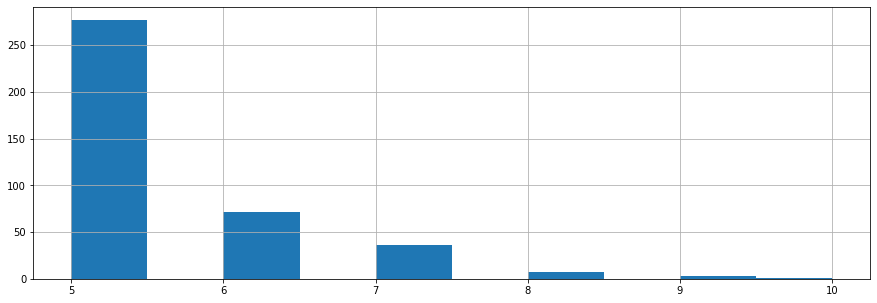

In [74]:
data.rooms.hist(range=(5,10), figsize = (15,5));

In [75]:
data = data[(data['rooms'] <= 7)]

<AxesSubplot:>

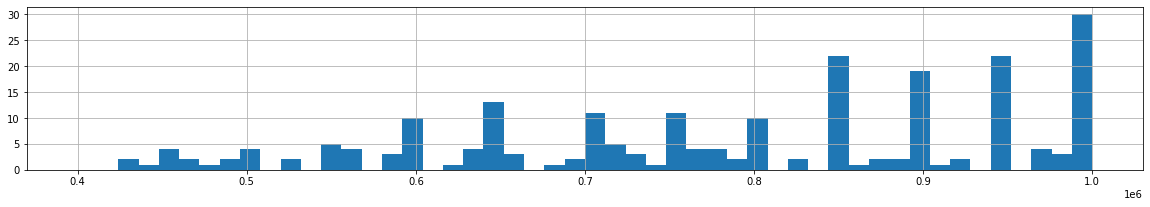

In [76]:
data.last_price.hist(bins=50, range=(400000,1000000), figsize = (20,3));

<AxesSubplot:>

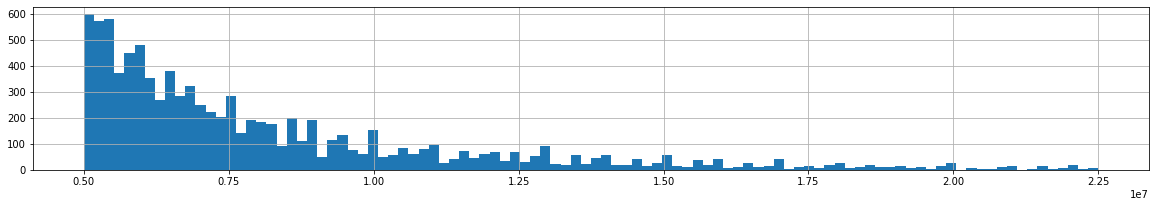

In [77]:
data.last_price.hist(bins=100, range=(5000000,22500000), figsize = (20,3));

In [78]:
data = data[(data['last_price'] <= 20000000) & (data['last_price'] >= 500000)]

<AxesSubplot:>

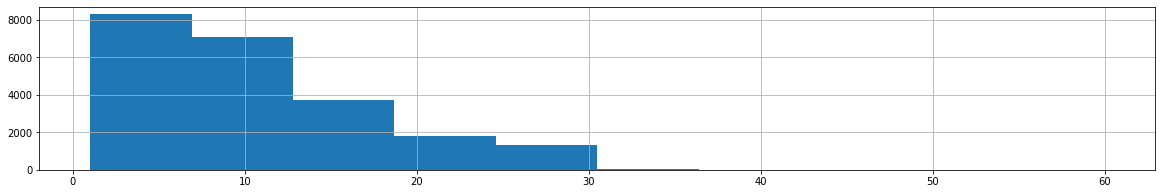

In [79]:
data.floors_total.hist(figsize = (20,3));

<AxesSubplot:>

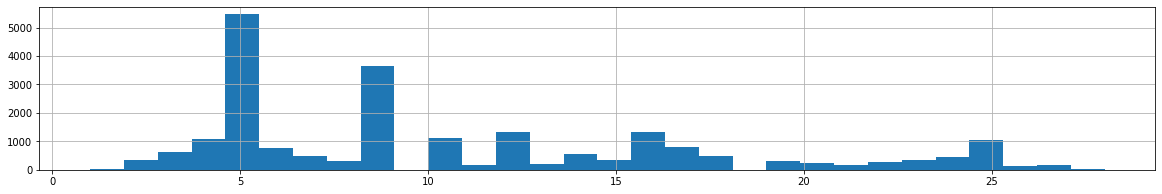

In [80]:
data.floors_total.hist(bins=30,range=(1,28),figsize = (20,3));

In [81]:
data = data[(data['floors_total'] <= 28) & (data['floors_total'] >= 2)]

<AxesSubplot:>

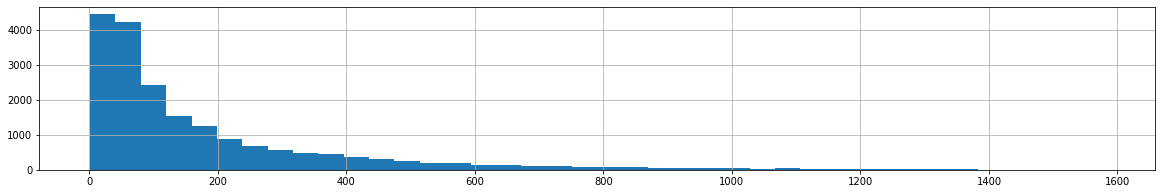

In [82]:
data.days_exposition.hist(bins=40,figsize = (20,3));

<AxesSubplot:>

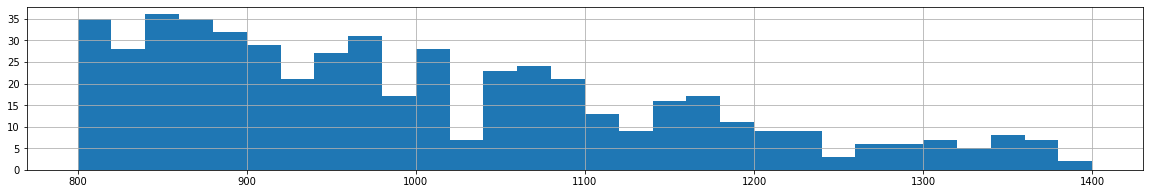

In [83]:
data.days_exposition.hist(bins=30, range=(800,1400),figsize = (20,3));

<AxesSubplot:>

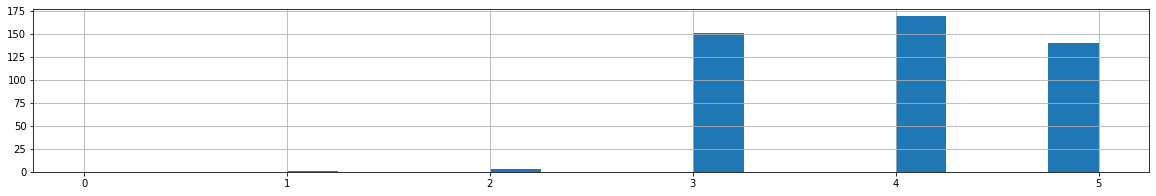

In [84]:
data.days_exposition.hist(bins=20, range=(0,5),figsize = (20,3));

In [85]:
data = data[(data['days_exposition'] < 1200) & (data['days_exposition'] > 2) | (data['days_exposition'].isna())]

<AxesSubplot:>

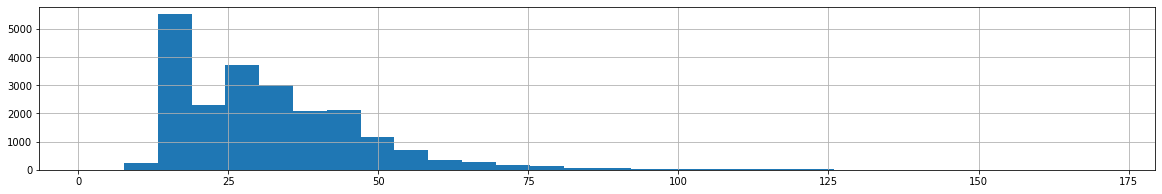

In [86]:
data.living_area.hist(bins=30, figsize = (20,3));

<AxesSubplot:>

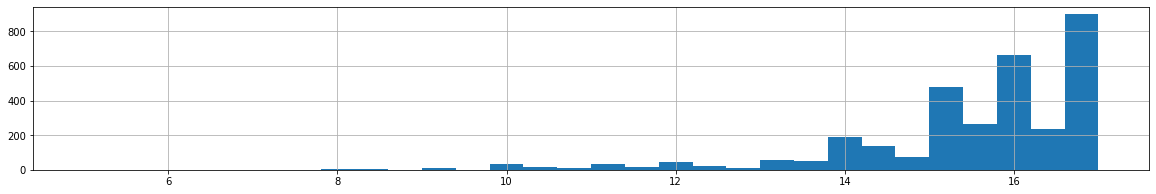

In [87]:
data.living_area.hist(bins=30, range=(5,17), figsize = (20,3));

<AxesSubplot:>

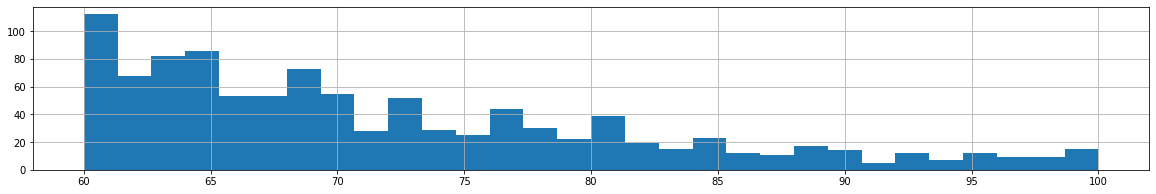

In [88]:
data.living_area.hist(bins=30, range=(60,100), figsize = (20,3));

In [89]:
data = data[(data['living_area'] <= 85) & (data['living_area'] >= 12)]

In [90]:
check_qvan(data)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,22.00,2.45,3.00,"601,664.00",12.00,-2.89,1.00,2.00
0.01,1.00,26.02,2.50,4.00,"1,050,000.00",14.00,1.75,1.00,2.00
0.5,2.00,50.60,2.65,92.00,"4,500,000.00",29.70,9.00,4.00,9.00
0.99,4.00,121.40,3.40,974.00,"16,500,000.00",74.40,26.50,22.00,26.00
0.9988,5.00,151.46,3.70,"1,161.53","19,797,504.00",83.00,42.31,26.00,27.00


In [91]:
check_param(data)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,737.00","21,737.00","21,737.00","18,947.00","21,737.00","21,737.00","21,737.00","21,737.00","21,737.00"
min,0.00,20.00,2.40,3.00,"500,000.00",12.00,-16.00,1.00,2.00
max,7.00,236.00,3.80,"1,199.00","20,000,000.00",85.00,49.40,27.00,28.00


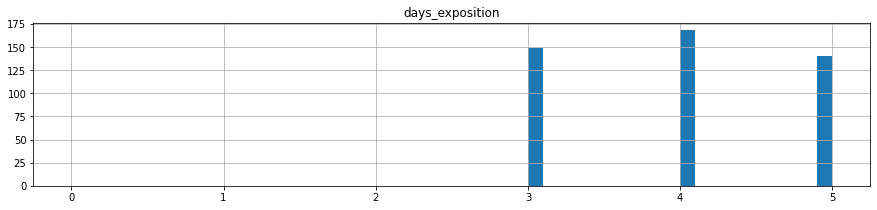

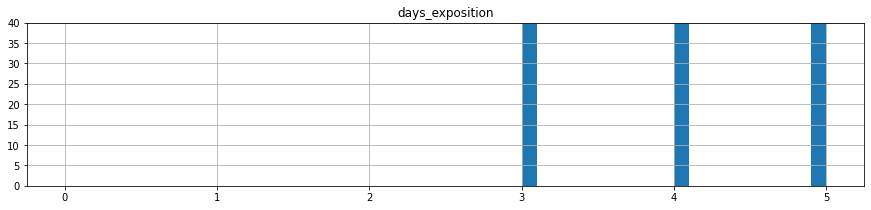

In [92]:
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

### Расчитываем и добавляем новые признаки

In [93]:
data['square_m_cost'] = data['last_price']/data['total_area']

In [94]:
data['day_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

In [95]:
len(data.query('floor < 1'))

0

In [96]:
data['floor_type'] = ['Первый' if data['floor'][i] == 1 
                      else 'Последний' if data['floor'][i] == data['floors_total'][i] 
                      else 'Другой'  for i in data.index]

In [97]:
data['dist_centr_km'] = (data['cityCenters_nearest']/1000).astype(int)

In [98]:
data.head(10)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21737 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21737 non-null  int64         
 1   last_price            21737 non-null  float64       
 2   total_area            21737 non-null  float64       
 3   first_day_exposition  21737 non-null  datetime64[ns]
 4   rooms                 21737 non-null  int64         
 5   ceiling_height        21737 non-null  float64       
 6   floors_total          21737 non-null  int64         
 7   living_area           21737 non-null  float64       
 8   floor                 21737 non-null  int64         
 9   is_apartment          21737 non-null  object        
 10  studio                21737 non-null  bool          
 11  open_plan             21737 non-null  bool          
 12  kitchen_area          21737 non-null  float64       
 13  balcony         

### Проведем исследовательский анализ данных

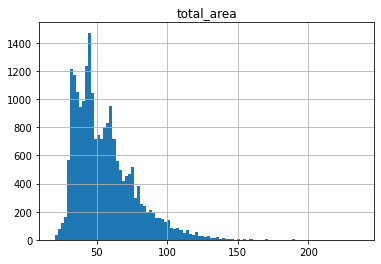

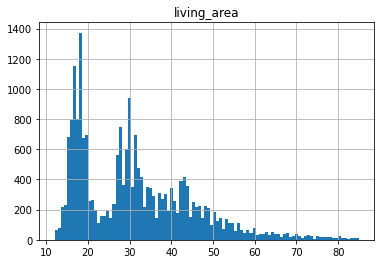

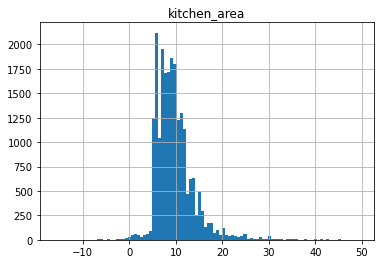

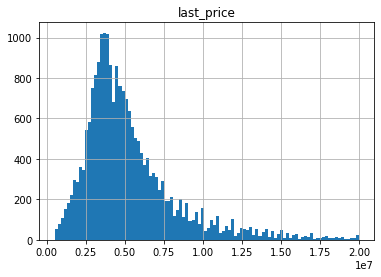

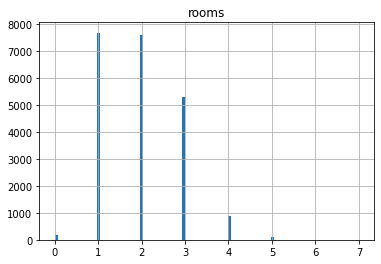

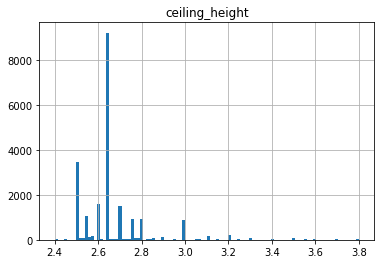

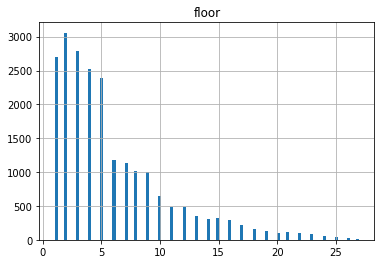

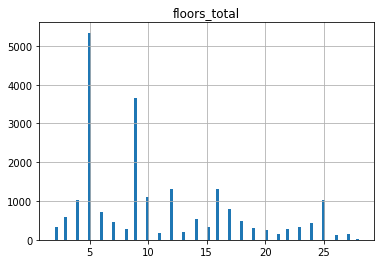

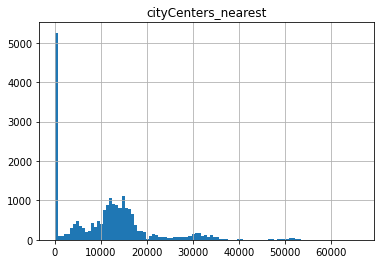

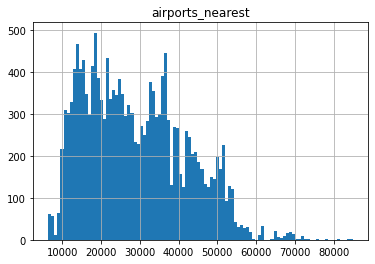

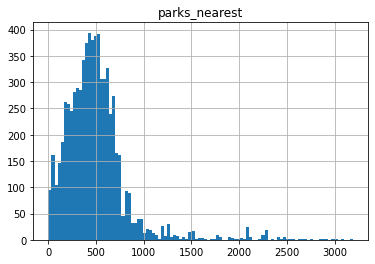

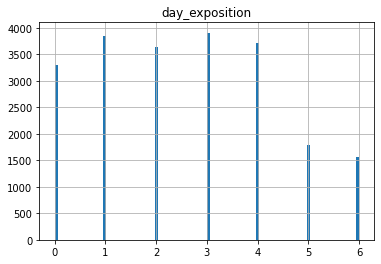

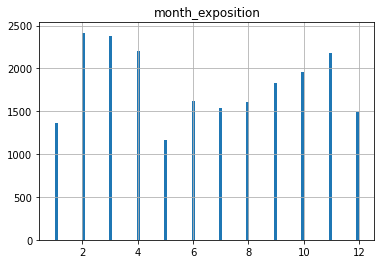

In [99]:
obj = ['total_area', 'living_area', 'kitchen_area', 
       'last_price', 'rooms', 'ceiling_height', 'floor', 
       'floors_total', 'cityCenters_nearest', 'airports_nearest', 
       'parks_nearest', 'day_exposition', 'month_exposition']
for i in obj:
    plt.hist(x=data[i], bins=100)
    plt.title(i)
    plt.grid(True)
    plt.show()


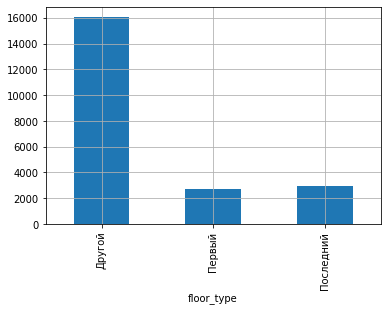

In [100]:
data.groupby(by='floor_type')['floor_type'].count().plot(kind='bar', grid=True);

*Общая площадь:* Основная масса квартир с площадью от 30 до 75 м2.

*Жилая площадь:* Как было установленно ранее, жилая площадь зависит от общей площади, какой то провал на гистограмме.

*Площадь кухни:* Основная масса кухонь составляет около 5-15 м2

*Цена объекта:* Основанной объем продающихся квартир в диапазоне 2,5-7,5 млн руб.

*Количество комнат:* С увеличением комнат, количество квартир падает.

*Высота потолков:* Нормальная высота потолков до 2,65.

*Этаж квартиры:* Чем ниже этаж, тем больше объявлений

*Тип этажа квартиры:* Наиболее распространенный тип: другой.

*Общее количество этажей в доме:* Типовая массовая застройка 5- и 9-этажки.

*Расстояние до центра города в метрах:* Большая часть квартир продается с растоянием до центра города до 20000 м.

*Расстояние до ближайего аэропорта:* Здесь ситуация немного другая, граница сдвинута до чуть более 50000 м. 

*Расстояние до ближайшего парка:* Если рядом имеется парк, скорее всего расстояние до него составляет до 1000 м.

*День и месяц публикации объявления:* Меньше всего объявлений выкладывалось в выходные. Пики приходятся на начало весны и осень, минимум - май.

172.43780017944795


92.0

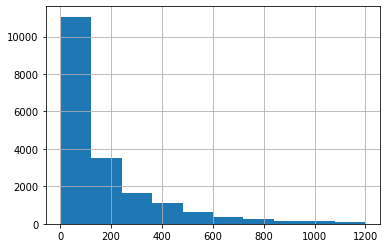

In [101]:
data['days_exposition'].hist()
print(data['days_exposition'].mean())
print(data['days_exposition'].median())

<AxesSubplot:>

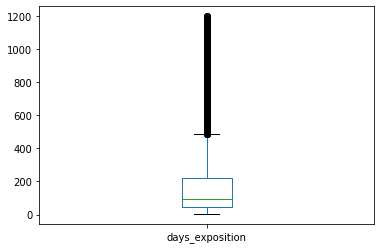

In [102]:
data['days_exposition'].plot(kind='box');

In [103]:
data['days_exposition'].describe()

count    18947.000000
mean       172.437800
std        203.629936
min          3.000000
25%         44.000000
50%         92.000000
75%        222.000000
max       1199.000000
Name: days_exposition, dtype: float64

Обычно время продажи квартиры составляет около 3 месяцев. Быстрыми продажами можно считать срок менее 1,5 месяцев. Необычно долгими можно считать продажи более 7 месяцев.

In [106]:
data = data.loc[data['last_price'] < 500000000]

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

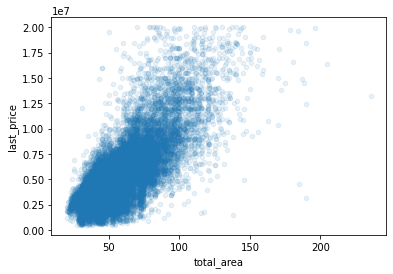

In [107]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.1);

Цена увеличивается от увеличения площади.

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

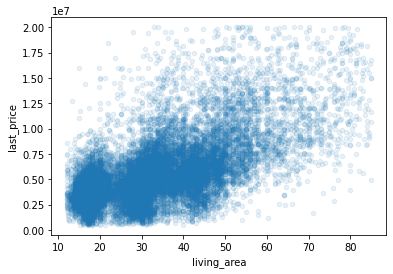

In [108]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.1);

Цена увеличивается от увеличения жилой площади.

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

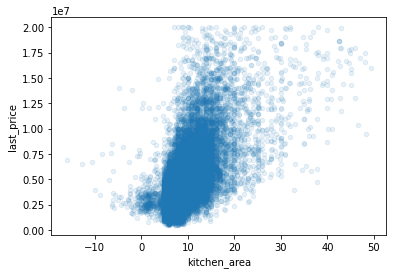

In [109]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.1);

Цена не зависит от площади кухни.

<AxesSubplot:xlabel='rooms'>

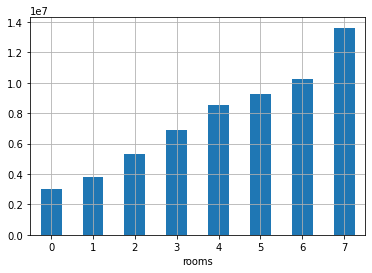

In [110]:
data.groupby(by='rooms')['last_price'].mean().plot(x='rooms', y='last_price', kind='bar', rot=0, grid=True);

Большее количество комнат предполагает большую площадь, а цена зависит от площади.

<AxesSubplot:xlabel='floor_type'>

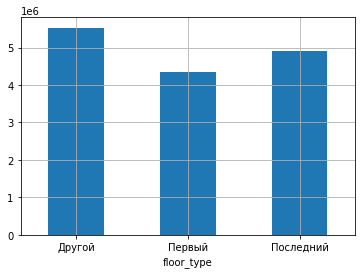

In [111]:
data.groupby(by='floor_type')['last_price'].mean().plot(x='floor_type', y='last_price', kind='bar', rot=0, grid=True);

Более дорогих квартир больше на других и последний этажах.

<AxesSubplot:xlabel='day_exposition'>

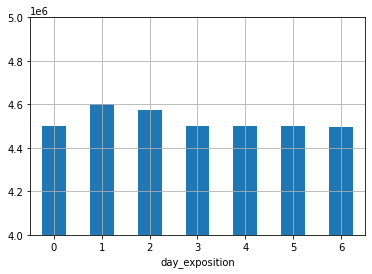

In [112]:
data.groupby(by='day_exposition')['last_price'].median().plot(x='day_exposition', y='last_price', 
                                                              kind='bar', rot=0, grid=True, ylim=(4000000,5000000));

<AxesSubplot:xlabel='day_exposition'>

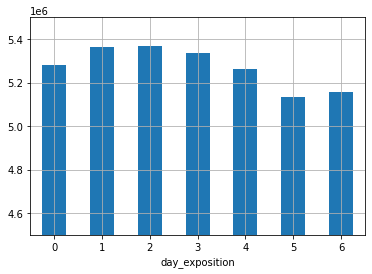

In [113]:
data.groupby(by='day_exposition')['last_price'].mean().plot(x='day_exposition', y='last_price', 
                                                            kind='bar', rot=0, grid=True, ylim=(4500000,5500000));

Можно сказать что объявления, размещенные во вторник были проданы по большей цене. Необходимо оценить коэффициент корреляции.

<AxesSubplot:xlabel='month_exposition'>

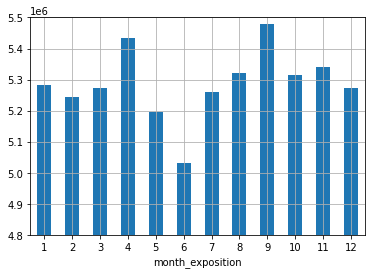

In [114]:
data.groupby(by='month_exposition')['last_price'].mean().plot(x='month_exposition', y='last_price', 
                                                              kind='bar', rot=0, grid=True, ylim=(4800000,5500000));

В среднем дешевле всего квартиры публиковались в начале лета.

<AxesSubplot:xlabel='year_exposition'>

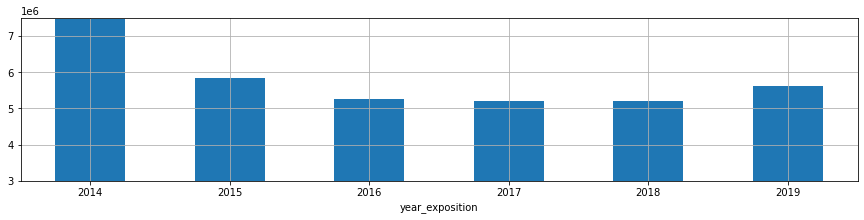

In [115]:
data.groupby(by='year_exposition')['last_price'].mean().plot(x='year_exposition', y='last_price', 
                                                             kind='bar', rot=0, grid=True, 
                                                             ylim=(3000000,7500000), figsize=(15,3));

<AxesSubplot:ylabel='year_exposition'>

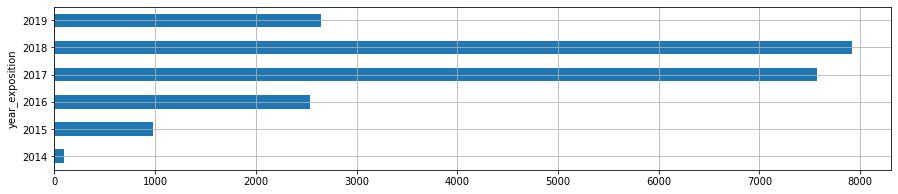

In [116]:
data.groupby(by='year_exposition')['total_area'].count().plot(kind='barh', rot=0, grid=True,  figsize=(15,3));

<AxesSubplot:xlabel='year_exposition'>

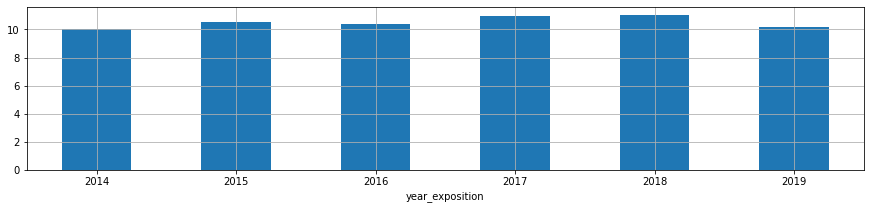

In [117]:
data.groupby(by='year_exposition')['floors_total'].mean().plot(x='year_exposition', y='floors_total', 
                                                               kind='bar', rot=0, grid=True,  figsize=(15,3));

<AxesSubplot:xlabel='year_exposition'>

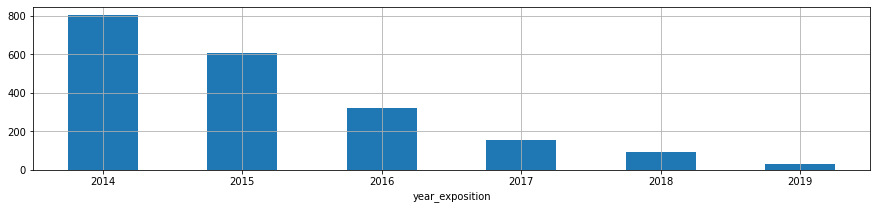

In [118]:
data.groupby(by='year_exposition')['days_exposition'].mean().plot(x='year_exposition', y='days_exposition', 
                                                                  kind='bar', rot=0, grid=True,  figsize=(15,3));

Медианная цена квартир была довольно высока в 14 году, падала к 16му и далее постепенно росла. Средняя площадь квартир притом не изменялась, количество объявлений с 16 по 17 год увеличилось в 3 раза. Этажность домов в 17 и 18 году возросла. С годами скорость продаж возростала.

In [119]:
print(data.loc[data['year_exposition'] == 2014, 'month_exposition'].min())
print(data.loc[data['year_exposition'] == 2014, 'month_exposition'].max())

11


12

In [120]:
print(data.loc[data['year_exposition'] == 2019, 'month_exposition'].min())
print(data.loc[data['year_exposition'] == 2019, 'month_exposition'].max())
print(data.loc[(data['year_exposition'] == 2019) & (data['month_exposition'] == 5), 'day_exposition'].max())

1
5


4

<AxesSubplot:ylabel='year_exposition'>

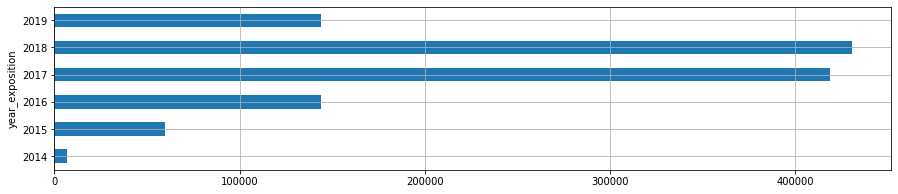

In [121]:
data.groupby(by='year_exposition')['total_area'].sum().plot(kind='barh', rot=0, grid=True,  figsize=(15,3));

<AxesSubplot:ylabel='year_exposition'>

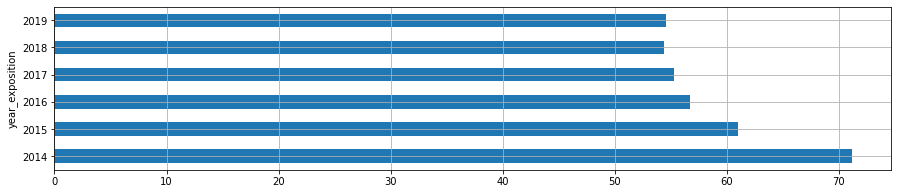

In [122]:
data.groupby(by='year_exposition')['total_area'].mean().plot(kind='barh', rot=0, grid=True,  figsize=(15,3));

In [123]:
for i in range(2014,2020):
    moda = data.loc[data['year_exposition'] == i, 'locality_name'].mode()
    count_localy = data.loc[(data['year_exposition'] == i) & (data['locality_name'] == moda[0]),'locality_name'].count()
    print(f'{i} год, больше всего объявлений: {moda[0]} - {count_localy}')
    

2014 год, больше всего объявлений: санкт-петербург - 66
2015 год, больше всего объявлений: санкт-петербург - 680
2016 год, больше всего объявлений: санкт-петербург - 1667
2017 год, больше всего объявлений: санкт-петербург - 5018
2018 год, больше всего объявлений: санкт-петербург - 4945
2019 год, больше всего объявлений: санкт-петербург - 1797


In [124]:
print('Исключая спб')
for i in range(2014,2020):
    moda = data.loc[(data['year_exposition'] == i) & (data['locality_name'] != 'санкт-петербург'), 'locality_name'].mode()
    count_localy = data.loc[(data['year_exposition'] == i) & (data['locality_name'] == moda[0]),'locality_name'].count()
    print(f'{i} год, больше всего объявлений: {moda[0]} - {count_localy}')
    

Исключая спб
2014 год, больше всего объявлений: колпино - 4
2015 год, больше всего объявлений: деревня кудрово - 22
2016 год, больше всего объявлений: поселок шушары - 69
2017 год, больше всего объявлений: поселок мурино - 194
2018 год, больше всего объявлений: поселок мурино - 247
2019 год, больше всего объявлений: гатчина - 36


<AxesSubplot:ylabel='year_exposition'>

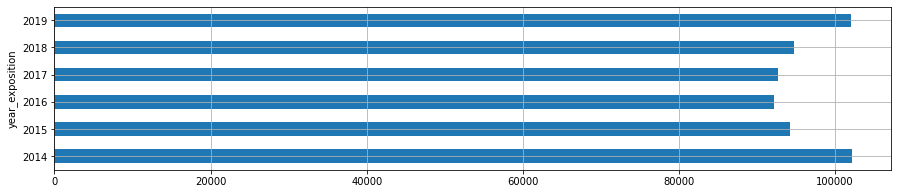

In [125]:
data.groupby(by='year_exposition')['square_m_cost'].mean().plot(kind='barh', rot=0, grid=True,  figsize=(15,3));

In [126]:
data.loc[:,['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type', 
            'day_exposition', 'month_exposition', 'year_exposition', 'days_exposition']].corr()

,last_price,total_area,living_area,kitchen_area,rooms,day_exposition,month_exposition,year_exposition,days_exposition
last_price,1.000000,0.756908,0.634689,0.582891,0.463821,-0.017058,0.007561,-0.010337,0.097044
total_area,0.756908,1.000000,0.917979,0.561636,0.786804,-0.015058,0.012254,-0.065859,0.132172
living_area,0.634689,0.917979,1.000000,0.278270,0.881538,-0.010072,0.005661,-0.054727,0.118521
kitchen_area,0.582891,0.561636,0.278270,1.000000,0.187735,-0.013651,0.011783,-0.036631,0.084011
rooms,0.463821,0.786804,0.881538,0.187735,1.000000,-0.003367,0.000436,-0.037074,0.094889
day_exposition,-0.017058,-0.015058,-0.010072,-0.013651,-0.003367,1.000000,0.012231,-0.004338,-0.018189
month_exposition,0.007561,0.012254,0.005661,0.011783,0.000436,0.012231,1.000000,-0.272065,-0.034518
year_exposition,-0.010337,-0.065859,-0.054727,-0.036631,-0.037074,-0.004338,-0.272065,1.000000,-0.595688
days_exposition,0.097044,0.132172,0.118521,0.084011,0.094889,-0.018189,-0.034518,-0.595688,1.000000


Итого больше всего цена зависит от площади квартиры. От дня, месяца, или года публикации объявлений стоимость квартир не зависит, значит, на графиках исследования временных показателей мы видим влияние других факторов. Чем больше год, тем меньше время продажи.

<AxesSubplot:xlabel='locality_name'>

Максимальная средняя стоимость квадратного метра: 108496.3
10-ая средняя стоимость квадратного метра: 58154.89


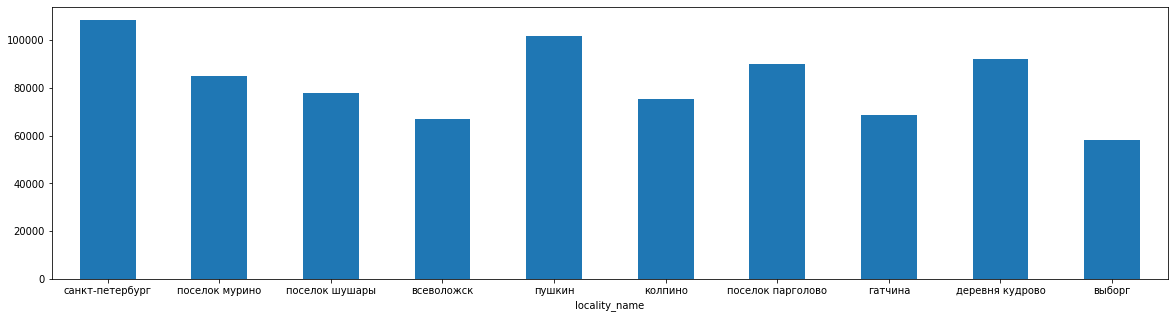

In [127]:
ex4 = data.pivot_table(index='locality_name', values='square_m_cost', aggfunc=['count', 'mean'])
ex4.columns = ['count', 'mean']
ex4 = ex4.sort_values('count', ascending=False).reset_index()
ex4 = ex4.loc[0:9,['locality_name','mean']]
display(ex4.plot.bar(x='locality_name', y='mean',legend=False, figsize=(20,5), rot=0));
print('Максимальная средняя стоимость квадратного метра:', round(ex4['mean'].max(),2))
print('10-ая средняя стоимость квадратного метра:', round(ex4['mean'].min(),2))

<AxesSubplot:xlabel='dist_centr_km'>

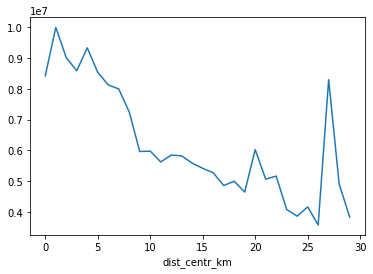

In [128]:
ex5 = data.loc[data['locality_name'] == 'санкт-петербург'].groupby(by='dist_centr_km')['last_price'].mean()
ex5.plot(x='dist_centr_km', y='mean');

<AxesSubplot:xlabel='dist_centr_km'>

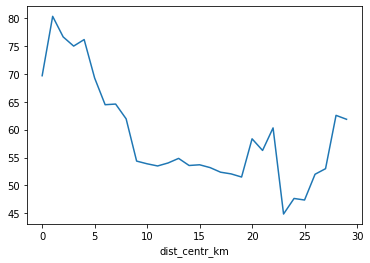

In [129]:
ex5 = data.loc[data['locality_name'] == 'санкт-петербург'].groupby(by='dist_centr_km')['total_area'].mean()
ex5.plot(x='dist_centr_km', y='mean');

<AxesSubplot:xlabel='dist_centr_km'>

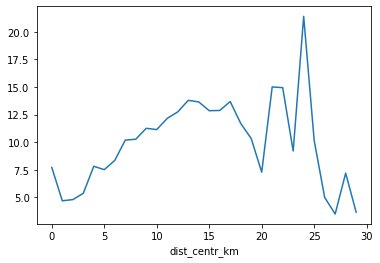

In [130]:
ex5 = data.loc[data['locality_name'] == 'санкт-петербург'].groupby(by='dist_centr_km')['floors_total'].mean()
ex5.plot(x='dist_centr_km', y='mean');

<AxesSubplot:xlabel='dist_centr_km'>

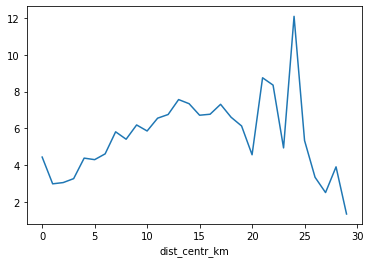

In [131]:
ex5 = data.loc[data['locality_name'] == 'санкт-петербург'].groupby(by='dist_centr_km')['floor'].mean()
ex5.plot(x='dist_centr_km', y='mean');

<AxesSubplot:xlabel='dist_centr_km'>

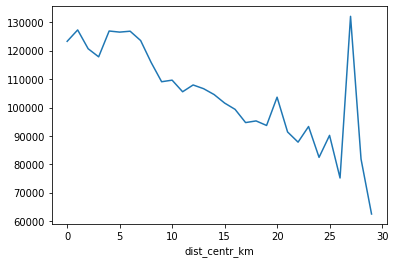

In [132]:
ex5 = data.loc[data['locality_name'] == 'санкт-петербург'].groupby(by='dist_centr_km')['square_m_cost'].mean()
ex5.plot(x='dist_centr_km', y='mean');

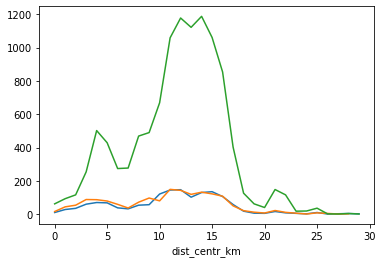

In [133]:
for i in ['Первый', 'Последний', 'Другой']:
    ex5 = data.loc[(data['floor_type'] == i) & \
                   (data['locality_name'] == 'санкт-петербург')].groupby(by='dist_centr_km')['total_area'].count()
    ex5.plot()

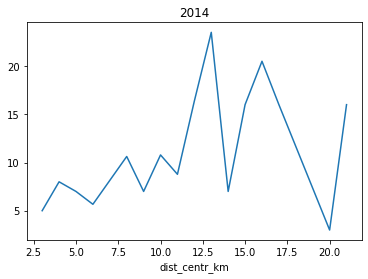

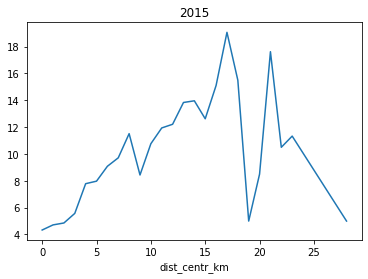

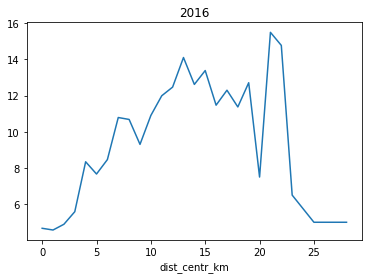

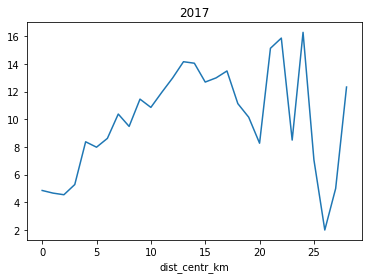

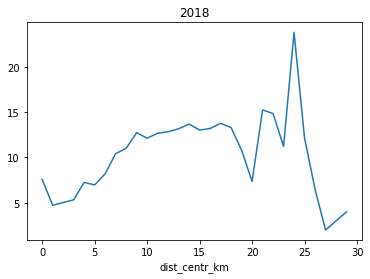

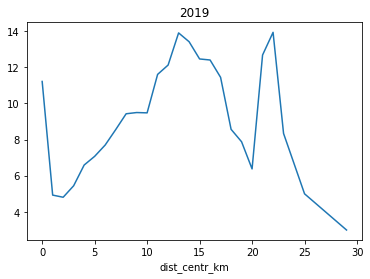

In [134]:
for i in range(2014,2020):
    ex5 = data.loc[(data['year_exposition'] == i) & \
                   (data['locality_name'] == 'санкт-петербург')].groupby(by='dist_centr_km')['floors_total'].mean()
    ex5.plot()
    plt.title(i)
    plt.show()


Так и есть, малоэтажное дорогое жилье, а перед 25 километром видим многоэтажную застройку с дешевыми квартирами - спальные районы. 

В среднем, чем выше этаж квартиры (дома), тем меньше площадь квартиры, что согласуется многоквартирным жильем ("муравейниками"). Ближе к центру больше малоэтажного жилья, но в радиусе 1 км от центра города c 2017 в продаже начала появляться многоэтажная застройка.

<AxesSubplot:xlabel='dist_centr_km', ylabel='last_price'>

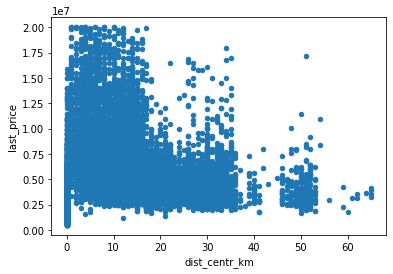

In [135]:
data.plot(x='dist_centr_km', y='last_price', kind='scatter');

Чем ближе к центру, тем дороже квартиры, а так же больше вариантов элитного жилья. 

### Общий вывод

Былf проведена предобработка данных - архива объявлений с 2014 по 2019 год о продаже квартир в Санкт-Петербурге и соседних населенных пунктах, с целью их изучения и посика особенностей и зависимостей.

- Были удалены малочисленные объявления с неуказанными населенными пунктами и общим числом этажей. 
- Пропуски в жилой площади были заменены на значения общей площади умноженный на средний коэффициент отношения жилой прощади к общей площади по архиву. 
- Для заполнения пропусков в площади кухни был определен средний коэффициент доли нежилого помещения (исключая площадь кухни). Площадь кухни рассчитывалась по общей и жилой площади, с учетом коэффициента, по остаточному рпинципу.
- Пропустки в высоте потолков заменили на медианную.
- Пропуски в параметре апартаментов заменили на "не апартаменты"
- Пропуски в ближайших парках и водоемах совпадали с пропусками в расстояниях до ближайших. Первые заменили на ноль, вторые оставили как есть.
- Определили и устранили неявные дубликаты в названии населенных пунктов, их было 46.
- Пропуски в расстоянии до центра населенного пункта и аэропорта заменили средним по населенному пункту. Оставшиеся пропуски в расстоянии до центра населенного пункта заменили на ноль.
- Были оценены причины пропусков как человеческие, так и программные. 

Были изменены типы данных, где это было целесообразно (этажность дома, количество балконов, количество парков и озер), определено, что все публикации датировались в полночь.

Устранены аномалии по площади кухни, высоте потолков, количеству балконов. Найдена квартира в аэропорте.

Дополнительно были определены:
- Стоимость квадратных метров квартир
- Номера дней недели, месеца и года публикации объявлений
- Типы этажей
- Расстояние до центра города в км

#### Анализ основных признаков показал:
*Общая площадь:* Основная масса квартир с площадью от 30 до 75 м2.

*Жилая площадь:* Как было установленно ранее, жилая площадь зависит от общей площади, какой то провал на гистограмме.

*Площадь кухни:* Основная масса кухонь составляет около 5-15 м2

*Цена объекта:* Основанной объем продающихся квартир в диапазоне 2,5-7,5 млн руб.

*Количество комнат:* С увеличением комнат, количество квартир падает.

*Высота потолков:* Нормальная высота потолков до 2,65.

*Этаж квартиры:* Чем ниже этаж, тем больше объявлений

*Тип этажа квартиры:* Наиболее распространенный тип: другой.

*Общее количество этажей в доме:* Типовая массовая застройка 5- и 9-этажки.

*Расстояние до центра города в метрах:* Большая часть квартир продается с растоянием до центра города до 20000 м.

*Расстояние до ближайего аэропорта:* Здесь ситуация немного другая, граница сдвинута до чуть более 50000 м. 

*Расстояние до ближайшего парка:* Если рядом имеется парк, скорее всего расстояние до него составляет до 1000 м.

*День и месяц публикации объявления:* Меньше всего объявлений выкладывалось в выходные. Пики приходятся на начало весны и осень, минимум - май.

Обычно время продажи квартиры составляет около 3 месяцев. Быстрыми продажами можно считать срок менее 1,5 месяцев. Необычно долгими можно считать продажи более 7 месяцев.

Больше всего цена квартиры зависит от ее площади.

Преимущественно квартиры продаются в Санкт-Петербурге, в других населенных пунктах они незначительны. По 19му году у нас есть только треть, и по количеству площади в продаже этот уровень соответсвует 2016 году. Цена одного квадратного метра растет, данные по 2014 году недостаточны. Средняя площадь квартир падает, увеличивается количество доступного жилья, повышается спрос и средняя стоимость квадратного метра растет.

В среднем, чем выше этаж квартиры (дома), тем меньше площадь квартиры, что согласуется многоквартирным жильем ("муравейниками"). Ближе к центру больше малоэтажного жилья, но в радиусе 1 км от центра города c 2017 в продаже начала появляться многоэтажная застройка.